In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import math
from collections import Counter


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepanshurao0001/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deepanshurao0001/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [7]:
def load_newsgroups():
    newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
    df = pd.DataFrame({'text': newsgroups.data, 'category': newsgroups.target})
    return df, newsgroups.target_names


In [9]:
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

In [11]:
from sklearn.preprocessing import normalize

In [13]:
def afe_mert_features(df, class_frequencies):
    terms = Counter()
    class_term_frequencies = {}

    for _, row in df.iterrows():
        class_label = row['category']
        text_tokens = preprocess_text(row['text'])
        terms.update(text_tokens)
        if class_label not in class_term_frequencies:
            class_term_frequencies[class_label] = Counter()
        class_term_frequencies[class_label].update(text_tokens)

    # Calculate RIR
    max_class_size = max(class_frequencies.values())
    rir = {cls: max_class_size / freq for cls, freq in class_frequencies.items()}

    # Create AFE-MERT features
    features = []
    for _, row in df.iterrows():
        text_tokens = preprocess_text(row['text'])
        doc_features = []
        for cls in class_frequencies.keys():
            score = 0
            for term in text_tokens:
                n_tk_ci = class_term_frequencies[cls].get(term, 0)
                idf = math.log(len(df) / (1 + terms[term]))
                A = class_term_frequencies[cls].get(term, 0)
                B = sum(class_term_frequencies[c].get(term, 0) for c in class_frequencies.keys() if c != cls)
                RIR_cls = rir[cls]
                score += math.log(1 + n_tk_ci) * idf * math.log(1 + RIR_cls ** 0.5) * math.log(1 + A / max(1, B))
            doc_features.append(score)
        features.append(doc_features)

    return normalize(np.array(features))

In [15]:
def visualize_model_contributions(model, feature_matrix, instance_index=0, title="Model Contributions"):
   
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(feature_matrix)

    print(f"\nVisualizing {title} for document at index {instance_index}...")

    shap.force_plot(
        explainer.expected_value[1],
        shap_values[1][instance_index],
        feature_matrix[instance_index],
        matplotlib=True
    )
    plt.title(f"{title} (Instance {instance_index})")
    plt.show()

    print(f"\nSummary of {title}:")
    shap.summary_plot(shap_values[1], feature_matrix, plot_type="bar")


In [17]:
newsgroups_df, target_names = load_newsgroups()


In [45]:
newsgroups_df['text'] = newsgroups_df['text'].fillna("").apply(lambda x: " ".join(preprocess_text(x)))
class_frequencies = newsgroups_df['category'].value_counts().to_dict()
train_df, test_df = train_test_split(newsgroups_df, test_size=0.3, stratify=newsgroups_df['category'], random_state=42)

In [46]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_baseline = tfidf_vectorizer.fit_transform(train_df['text']).toarray()
X_test_baseline = tfidf_vectorizer.transform(test_df['text']).toarray()
X_train_afe = afe_mert_features(train_df, class_frequencies)
X_test_afe = afe_mert_features(test_df, class_frequencies)
y_train = train_df['category']
y_test = test_df['category']

In [47]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_baseline, y_train)

In [48]:
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train_baseline, y_train)


In [49]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [51]:
rf_model.fit(X_train_smote, y_train_smote)
smote_predictions = rf_model.predict(X_test_baseline)
print("\nSMOTE Model Results:")
print(classification_report(y_test, smote_predictions, target_names=target_names))



SMOTE Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.36      0.32      0.34       240
           comp.graphics       0.52      0.52      0.52       292
 comp.os.ms-windows.misc       0.57      0.56      0.57       296
comp.sys.ibm.pc.hardware       0.48      0.54      0.51       295
   comp.sys.mac.hardware       0.58      0.51      0.54       289
          comp.windows.x       0.61      0.66      0.63       296
            misc.forsale       0.64      0.69      0.66       293
               rec.autos       0.37      0.60      0.46       297
         rec.motorcycles       0.59      0.48      0.53       299
      rec.sport.baseball       0.61      0.50      0.55       298
        rec.sport.hockey       0.66      0.78      0.71       300
               sci.crypt       0.71      0.64      0.67       297
         sci.electronics       0.45      0.45      0.45       295
                 sci.med       0.61      0.63      0.

In [52]:
rf_model.fit(X_train_under, y_train_under)
under_predictions = rf_model.predict(X_test_baseline)
print("\nUndersampling Model Results:")
print(classification_report(y_test, under_predictions, target_names=target_names))


Undersampling Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.40      0.37      0.38       240
           comp.graphics       0.52      0.49      0.50       292
 comp.os.ms-windows.misc       0.54      0.55      0.54       296
comp.sys.ibm.pc.hardware       0.45      0.44      0.45       295
   comp.sys.mac.hardware       0.54      0.50      0.52       289
          comp.windows.x       0.56      0.66      0.60       296
            misc.forsale       0.60      0.67      0.63       293
               rec.autos       0.37      0.62      0.47       297
         rec.motorcycles       0.59      0.48      0.53       299
      rec.sport.baseball       0.61      0.44      0.51       298
        rec.sport.hockey       0.61      0.76      0.68       300
               sci.crypt       0.70      0.63      0.66       297
         sci.electronics       0.48      0.41      0.45       295
                 sci.med       0.60      0.63

In [53]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Train the model with class weights
rf_model.fit(X_train_baseline, y_train, sample_weight=[class_weight_dict[label] for label in y_train])
weight_predictions = rf_model.predict(X_test_baseline)
print("\nClass Weighting Model Results:")
print(classification_report(y_test, weight_predictions, target_names=target_names))



Class Weighting Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.46      0.31      0.37       240
           comp.graphics       0.50      0.48      0.49       292
 comp.os.ms-windows.misc       0.57      0.56      0.56       296
comp.sys.ibm.pc.hardware       0.48      0.51      0.49       295
   comp.sys.mac.hardware       0.55      0.50      0.52       289
          comp.windows.x       0.57      0.67      0.62       296
            misc.forsale       0.64      0.70      0.67       293
               rec.autos       0.36      0.60      0.45       297
         rec.motorcycles       0.55      0.48      0.51       299
      rec.sport.baseball       0.57      0.48      0.52       298
        rec.sport.hockey       0.64      0.75      0.69       300
               sci.crypt       0.71      0.64      0.67       297
         sci.electronics       0.44      0.46      0.45       295
                 sci.med       0.60      0.

In [54]:
rf_model.fit(X_train_afe, y_train)
afe_predictions = rf_model.predict(X_test_afe)
print("\nAFE-MERT Model Results:")
print(classification_report(y_test, afe_predictions, target_names=target_names))



AFE-MERT Model Results:
                          precision    recall  f1-score   support

             alt.atheism       0.88      0.64      0.74       240
           comp.graphics       0.69      0.83      0.75       292
 comp.os.ms-windows.misc       0.82      0.72      0.77       296
comp.sys.ibm.pc.hardware       0.82      0.77      0.79       295
   comp.sys.mac.hardware       0.86      0.75      0.80       289
          comp.windows.x       0.86      0.85      0.86       296
            misc.forsale       0.89      0.84      0.87       293
               rec.autos       0.58      0.83      0.68       297
         rec.motorcycles       0.88      0.85      0.86       299
      rec.sport.baseball       0.93      0.85      0.89       298
        rec.sport.hockey       0.95      0.91      0.93       300
               sci.crypt       0.72      0.90      0.80       297
         sci.electronics       0.83      0.76      0.79       295
                 sci.med       0.90      0.88     

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Collect results into a DataFrame for visualization
results = pd.DataFrame({
    "Technique": ["SMOTE", "Undersampling", "Class Weighting", "AFE-MERT"],
    "Precision": [
        classification_report(y_test, smote_predictions, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, under_predictions, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, weight_predictions, output_dict=True)['weighted avg']['precision'],
        classification_report(y_test, afe_predictions, output_dict=True)['weighted avg']['precision']
    ],
    "Recall": [
        classification_report(y_test, smote_predictions, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, under_predictions, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, weight_predictions, output_dict=True)['weighted avg']['recall'],
        classification_report(y_test, afe_predictions, output_dict=True)['weighted avg']['recall']
    ],
    "F1-Score": [
        classification_report(y_test, smote_predictions, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, under_predictions, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, weight_predictions, output_dict=True)['weighted avg']['f1-score'],
        classification_report(y_test, afe_predictions, output_dict=True)['weighted avg']['f1-score']
    ]
})

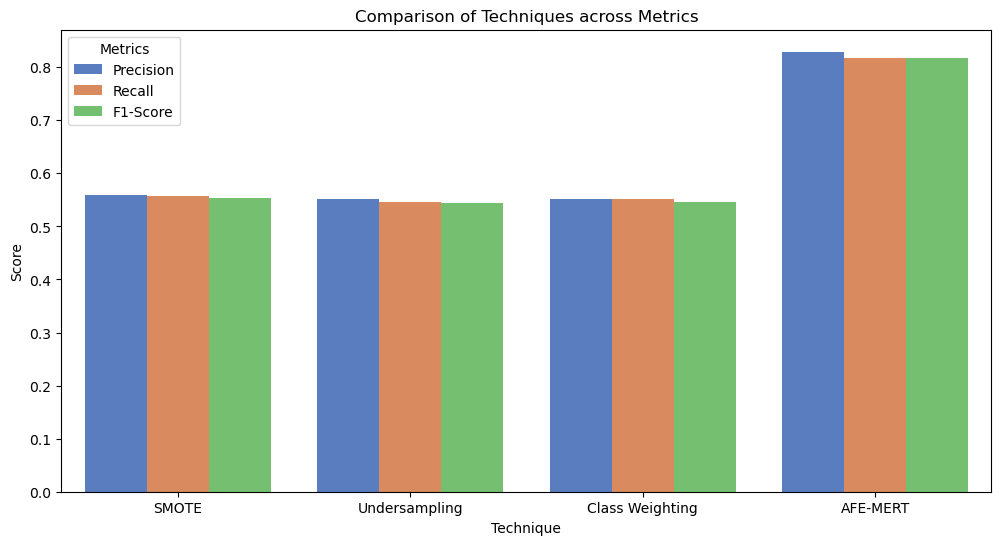

In [56]:
# Bar plot for comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=results.melt(id_vars="Technique"), x="Technique", y="value", hue="variable", palette="muted")
plt.title("Comparison of Techniques across Metrics")
plt.ylabel("Score")
plt.xlabel("Technique")
plt.legend(title="Metrics")
plt.show()


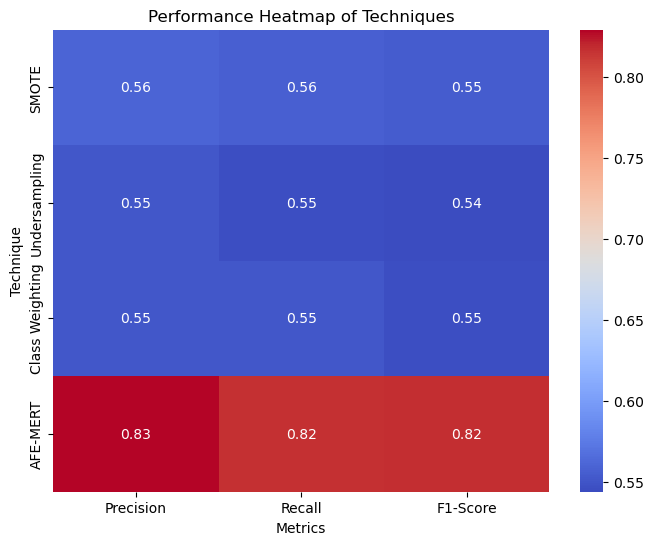

In [57]:
# Heatmap for metrics
plt.figure(figsize=(8, 6))
sns.heatmap(results.set_index("Technique"), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Performance Heatmap of Techniques")
plt.ylabel("Technique")
plt.xlabel("Metrics")
plt.show()
